train acc loading | 1.0


/var/folders/qf/rq2lntbj58jc3zz40tjwljw00000gn/T/ipykernel_96078/1438309233.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


train acc maintenance| 1.0


/var/folders/qf/rq2lntbj58jc3zz40tjwljw00000gn/T/ipykernel_96078/1438309233.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


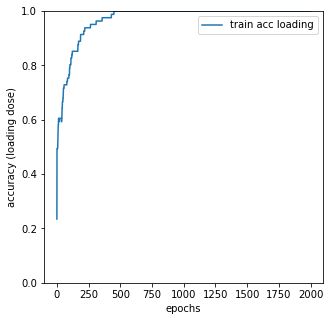

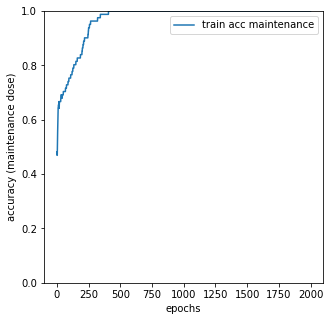

In [10]:
#TEIC-module 4.1 (model construction/trained with "non"-experts data)

#enter the filepath2 and 3 before running the program

filepath1 ="../dataset/TEIC_data(non-expert_non-ICU)(TEIC-table11).csv" #filepath to the dataset (TEIC-table11)
filepath2 ="" #filepath to the folder where to save the weight parameters
filepath3 ="" #filepath to the folder where to save figure

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def one_hot_encoding(x):
    unique = list(np.unique(x))
    for i in unique:
        x = np.where(x == i, unique.index(i), x)
    x = np.ravel(x).astype(int)
    one_hot = np.eye(len(np.unique(x)))[x]
    return unique, one_hot                                                                                             
                                                                                                                       
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # overflow
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.res

def sigmoid(x):
    return 1 / (1 + np.exp(-x))  

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size).astype(np.float32)
        self.params['b1'] = np.zeros(hidden_size).astype(np.float32)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size).astype(np.float32)
        self.params['b2'] = np.zeros(output_size).astype(np.float32)
        self.h ={}
        self.h['W1'] = np.zeros_like(self.params['W1'])
        self.h['b1'] = np.zeros_like(self.params['b1'])
        self.h['W2'] = np.zeros_like(self.params['W2'])
        self.h['b2'] = np.zeros_like(self.params['b2'])


    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:input, t:output
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

    
data = pd.read_csv(str(filepath1))

ID = np.array(data[["index"]])
param_list1=["Age","body weight","BMI","Creatinine clearance","Alb","TO"]
param_list2 = ["T1","T2","T3","T4","T5","T6","T7"]
parameter1 = np.array(data[param_list1]).astype(np.float32) #patameter1の抽出
parameter2 = np.array(data[param_list2]) #patameter2の抽出
loading = np.array(data[["loading dose"]])#loadingの抽出
maintenance = np.array(data[["maintenance dose"]]) #維持量の抽出 
TDM = np.array(data[["TDM","TDM exclusion criteria"]])


#transform loading dose to one-hot encoding
ll, loading_one_hot = one_hot_encoding(loading)

#transform maintenance dose to one-hot encoding
lm, maintenance_one_hot =one_hot_encoding(maintenance)


sc = StandardScaler()
sc.fit(parameter1)
parameter_scale= sc.transform(parameter1)
parameter = np.concatenate([parameter_scale, parameter2], 1)    

#transform loading dose to one-hot encoding
ll, loading_one_hot = one_hot_encoding(loading)

#transform maintenance dose to one-hot encoding
lm, maintenance_one_hot = one_hot_encoding(maintenance)

#deep learning for loading dose
network_loading = TwoLayerNet(input_size=len(param_list1)+len(param_list2), hidden_size=15, output_size=len(np.unique(loading)))

iters_num = 2000  #iteration

j=0.1 # learning rate
learning_rate = j
train_loss_loading_list = []
train_acc_loading_list = []


for i in range(iters_num):
    #grads = network.numerical_gradient(x_batch, t_batch)
    grads = network_loading.gradient(parameter, loading_one_hot)
    #update
    for key in ('W1', 'b1', 'W2', 'b2'):
        network_loading.h[key] += grads[key] * grads[key]
        network_loading.params[key] -= learning_rate * grads[key]/(np.sqrt(network_loading.h[key])+1e-7)
    loss = network_loading.loss(parameter, loading_one_hot)
    train_loss_loading_list.append(loss)
    train_acc_loading = network_loading.accuracy(parameter, loading_one_hot)
    train_acc_loading_list.append(train_acc_loading)
np.save(str(filepath2)+"/loading.param(W1)_non-expert.npy", network_loading.params["W1"])
np.save(str(filepath2)+"/loading.param(b1)_non-expert.npy", network_loading.params["b1"])
np.save(str(filepath2)+"/loading.param(W2)_non-expert.npy", network_loading.params["W2"])
np.save(str(filepath2)+"/loading.param(b2)_non-expert.npy", network_loading.params["b2"])
print("train acc loading | " + str(train_acc_loading) )
# graph
fig1 = plt.figure(figsize=(5.0, 5.0))
x = np.arange(len(train_acc_loading_list))
plt.plot(x, train_acc_loading_list, label="train acc loading")
plt.xlabel("epochs")
plt.ylabel("accuracy (loading dose)")
plt.ylim(0, 1.0)
plt.legend(loc="best")
fig1.show()
fig1.savefig(str(filepath3)+"/epoch-accuracy(loading).png",format="png", dpi=300)

#deep learning for maintenance dose
network_maintenance = TwoLayerNet(input_size=len(param_list1)+len(param_list2), hidden_size=15, output_size=len(np.unique(maintenance)))

j=0.1 # learning rate
learning_rate = j
train_loss_maintenance_list = []
train_acc_maintenance_list = []


for i in range(iters_num):
    #grads = network.numerical_gradient(x_batch, t_batch)
    grads = network_maintenance.gradient(parameter, maintenance_one_hot)
    #update
    for key in ('W1', 'b1', 'W2', 'b2'):
        network_maintenance.h[key] += grads[key] * grads[key]
        network_maintenance.params[key] -= learning_rate * grads[key]/(np.sqrt(network_maintenance.h[key])+1e-7)
    loss = network_maintenance.loss(parameter, maintenance_one_hot)
    train_loss_maintenance_list.append(loss)
    train_acc_maintenance = network_maintenance.accuracy(parameter, maintenance_one_hot)
    train_acc_maintenance_list.append(train_acc_maintenance)
np.save(str(filepath2)+"/maintenance.param(W1)_non-expert.npy", network_maintenance.params["W1"])
np.save(str(filepath2)+"/maintenance.param(b1)_non-expert.npy", network_maintenance.params["b1"])
np.save(str(filepath2)+"/maintenance.param(W2)_non-expert.npy", network_maintenance.params["W2"])
np.save(str(filepath2)+"/maintenance.param(b2)_non-expert.npy", network_maintenance.params["b2"])
print("train acc maintenance| " + str(train_acc_maintenance))
# graph
fig2 = plt.figure(figsize=(5.0, 5.0))
x = np.arange(len(train_acc_maintenance_list))
plt.plot(x, train_acc_maintenance_list, label="train acc maintenance")
plt.xlabel("epochs")
plt.ylabel("accuracy (maintenance dose)")
plt.ylim(0, 1.0)
plt.legend(loc="best" )

fig2.show()
fig2.savefig(str(filepath3)+"/epoch-accuracy(maintenance).png",format="png", dpi=300)

In [1]:
#TEIC-module 4.2 (model evaluation)

filepath1 ="../dataset/TEIC_non-ICU_test_rs4(TEIC-table20).csv" #file path to the testing data (TEIC-table 20)
filepath2 ="../dataset/TEIC_data(non-expert_non-ICU)(TEIC-table11).csv" #file path to the training data (TEIC-table 11)
filepath3 ="../weight parameter/internal validation (non-expertML)" #folder containing weight parameter

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def one_hot_encoding(x):
    unique = list(np.unique(x))
    for i in unique:
        x = np.where(x == i, unique.index(i), x)
    x = np.ravel(x).astype(int)
    one_hot = np.eye(len(np.unique(x)))[x]
    return unique, one_hot 


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # overflow
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.res

def sigmoid(x):
    return 1 / (1 + np.exp(-x))  

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:input, t:output
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

k = 4 #random state
data = pd.read_csv(filepath1)#test data
data_2 = pd.read_csv(filepath2)#training data for scaler and one-hot encoding
param_list1=["Age","body weight","BMI","Creatinine clearance","Alb","TO"]
param_list2 = ["T1","T2","T3","T4","T5","T6","T7"]
param_list3 = ["index"]


parameter1 = np.array(data[param_list1]) #parameter1 (numerical)
parameter2 = np.array(data[param_list2]) #parameter2 (binary)
parameter_model=np.array(data_2[param_list1]) #parameter (numerical) in training data
ID = np.array(data[param_list3])
loading_model = np.array(data_2[["loading dose"]])#loading dose in training data
maintenance_model = np.array(data_2[["maintenance dose"]]) #maintenance dose in training data
loading = np.array(data[["loading dose"]])
maintenance = np.array(data[["maintenance dose"]])
TDM = np.array(data[["TDM","TDM exclusion criteria"]])

#transform loading dose to one-hot encoding
ll, loading_one_hot = one_hot_encoding(loading_model)

#transform maintenance dose to one-hot encoding
lm, maintenance_one_hot = one_hot_encoding(maintenance_model)


sc = StandardScaler()
sc.fit(parameter_model)
parameter1_scaler = sc.transform(parameter1)
parameter_scaler = np.concatenate([parameter1_scaler, parameter2], 1)      
    
#loading
network_loading = TwoLayerNet(input_size=len(param_list1)+len(param_list2), hidden_size=15, output_size=len(np.unique(loading_model)))

#parameter incorporation
for key in ('W1', 'b1', 'W2', 'b2'):
    network_loading.params[key] = np.load(str(filepath3)+"/loading.param({})_non-expert.npy".format(key))
    

pred_loading_one_hot_to_index = list(np.argmax(network_loading.predict(parameter_scaler),axis=1))
pred_loading_dose = np.array([ll[i] for i in pred_loading_one_hot_to_index]).reshape((len(pred_loading_one_hot_to_index), 1))


#maintenance
network_maintenance = TwoLayerNet(input_size=len(param_list1)+len(param_list2), hidden_size=15, output_size=len(np.unique(maintenance_model)))

#parameter incorporation
for key in ('W1', 'b1', 'W2', 'b2'):
    network_maintenance.params[key] = np.load(str(filepath3)+"/maintenance.param({})_non-expert.npy".format(key))
    

pred_maintenance_one_hot_to_index = list(np.argmax(network_maintenance.predict(parameter_scaler),axis=1))
pred_maintenance_dose = np.array([lm[i] for i in pred_maintenance_one_hot_to_index]).reshape(len(pred_maintenance_one_hot_to_index), 1)

np_result = np.concatenate([ID, parameter1,parameter2, loading, pred_loading_dose,maintenance,pred_maintenance_dose, TDM],1)
df_list = param_list3+param_list1+param_list2+["loading dose","pred_loading dose","maintenance dose","pred_maintenance dose","TDM","TDM exclusion criteria"]
df_result = pd.DataFrame(data = np_result, columns= df_list)
display(df_result)


,index,Age,body weight,BMI,Creatinine clearance,Alb,TO,T1,T2,T3,T4,T5,T6,T7,loading dose,pred_loading dose,maintenance dose,pred_maintenance dose,TDM,TDM exclusion criteria
0,16,89.0,46.5,17.5016,49.160446,2.2,9.0,0,1,0,0,0,0,0,400 mg 4 doses,400 mg 4 doses,300 mg,400 mg,12.5,0
1,3,86.0,56.0,21.2071,23.595505,3.8,16.0,1,0,0,0,0,0,0,500 mg 4 doses,400 mg 4 doses,0 mg,0 mg,none,0
2,29,77.0,56.200001,24.133886,72.066811,2.2,16.0,0,0,0,0,1,0,0,600 mg 4 doses,400 mg 4 doses,400 mg,400 mg,41.4,0
3,19,80.0,49.799999,20.152283,37.930107,3.4,9.0,0,0,0,1,0,0,0,400 mg 4 doses,400 mg 4 doses,200 mg,400 mg,15.9,0
4,23,65.0,40.200001,17.06119,16.421568,2.0,10.0,0,0,0,0,1,0,0,400 mg 4 doses,200 mg 3 doses,200 mg,200 mg,19.6,0
5,50,72.0,46.0,17.746229,38.789684,3.3,10.0,0,0,0,1,0,0,0,400 mg 4 doses,400 mg 4 doses,200 mg,400 mg,18.6,0
6,6,56.0,76.900002,26.608997,46.972076,2.1,9.0,0,0,1,0,0,0,0,800 mg 3 doses,400 mg 4 doses,0 mg,0 mg,21,0
7,28,23.0,47.700001,20.113005,173.383224,2.8,15.0,0,1,0,0,0,0,0,500 mg 4 doses,200 mg 4 doses,300 mg,0 mg,23.3,0
8,109,30.0,53.900002,22.34837,44.58289,2.1,9.0,0,1,0,0,0,0,0,400 mg 4 doses,400 mg 4 doses,400 mg,0 mg,29.1,0
9,24,64.0,55.0,19.486961,29.772079,3.5,10.0,0,0,1,0,0,0,0,600 mg 3 doses,400 mg 3 doses,0 mg,0 mg,21.2,0
